# Attention Maps from DINO (ViT-S/16)

Notebook adapts the visualization script from the authors: https://github.com/facebookresearch/dino/blob/main/visualize_attention.py

In [1]:
import os
import warnings

import matplotlib.colors as colors
import matplotlib.pyplot as plt
import pandas as pd
import pytorch_lightning as pl
import seaborn as sns
import torch
import torch.nn as nn

from ssl_wafermap.models.knn import DINOViT
from ssl_wafermap.utilities.transforms import get_inference_transforms

torch.set_float32_matmul_precision("high")
sns.set_style("white")
sns.set_context("paper", font_scale=1.75)
pl.seed_everything(42)

# Ignore pytorch lightning warning about dataloader workers
warnings.filterwarnings("ignore", message=".*does not have many workers.*")

Global seed set to 42


In [95]:
# Load dataframe
df_full = pd.read_pickle("../data/processed/WM811K/train_data.pkl.xz")

# Load model from checkpoint and set to eval mode
ckpt_path = "../models/new_knn/DINOViT/checkpoints/epoch=149-step=87450.ckpt"
model = DINOViT()
model.load_from_checkpoint(ckpt_path)

for p in model.parameters():
    p.requires_grad = False

model.eval()
model.to("cuda");

Using cache found in C:\Users\khanm/.cache\torch\hub\facebookresearch_dino_main
Using cache found in C:\Users\khanm/.cache\torch\hub\facebookresearch_dino_main


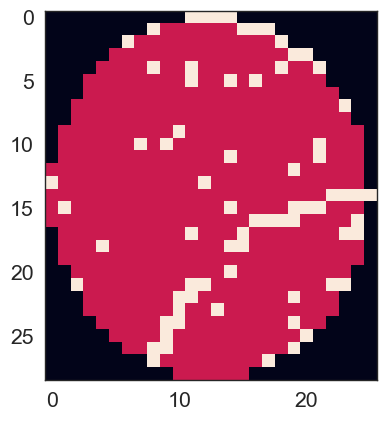

In [89]:
# Select a random wafer map with the "Edge-Ring" defect
random_image = df_full[df_full.failureType == "Scratch"].sample(1).waferMap.values[0]
plt.imshow(random_image);

In [90]:
transforms = get_inference_transforms()
img = transforms(random_image)

patch_size = 16

# make the image divisible by the patch size (16)
w, h = img.shape[1] - img.shape[1] % patch_size, img.shape[2] - img.shape[2] % patch_size
img = img[:, :w, :h].unsqueeze(0)

w_featmap = img.shape[-2] // patch_size
h_featmap = img.shape[-1] // patch_size

attentions = model.backbone.get_last_selfattention(img.to("cuda"))

nh = attentions.shape[1] # number of head

# we keep only the output patch attention
attentions = attentions[0, :, 0, 1:].reshape(nh, -1)

# Skip the thresholding step, kinda confusing...

attentions = attentions.reshape(nh, w_featmap, h_featmap)
attentions = nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].cpu().numpy()

Now we plot the original image, attention maps, and save to file.

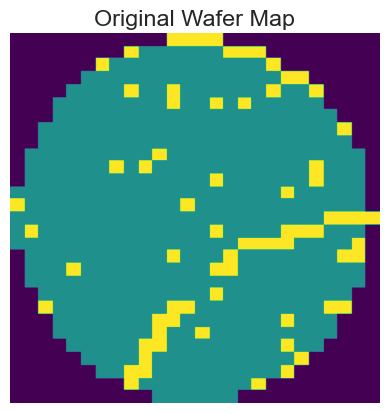

In [93]:
save_path = "../reports/figures/DINO_attention"
os.makedirs(save_path, exist_ok=True)

plt.imshow(img.squeeze(0)[0], cmap="viridis", alpha=1)
plt.title("Original Wafer Map")
plt.axis("off")
plt.savefig(f"{save_path}/attention_original.png", bbox_inches="tight")
plt.show()

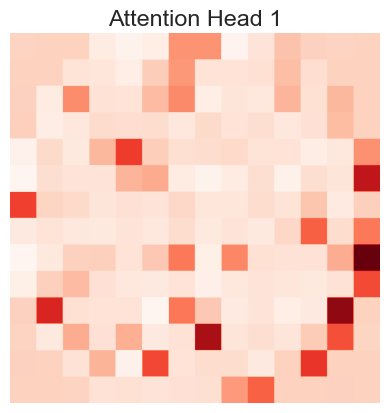

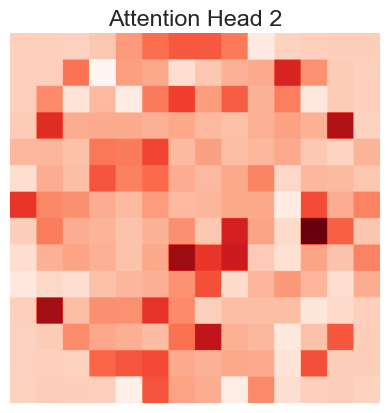

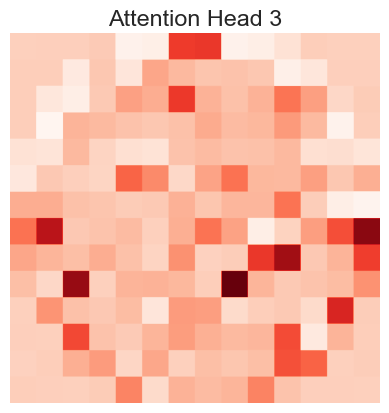

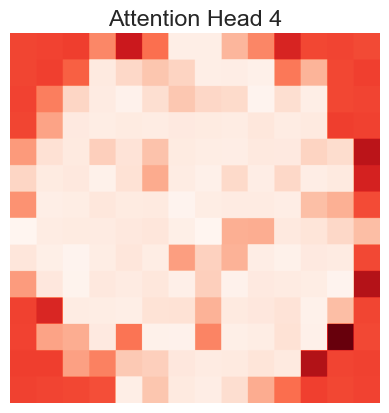

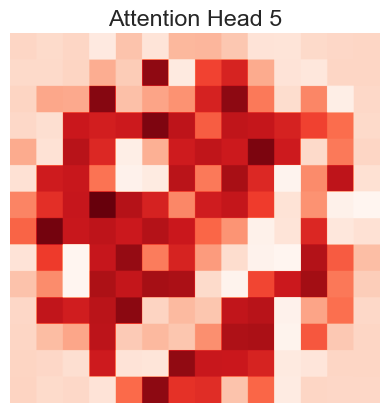

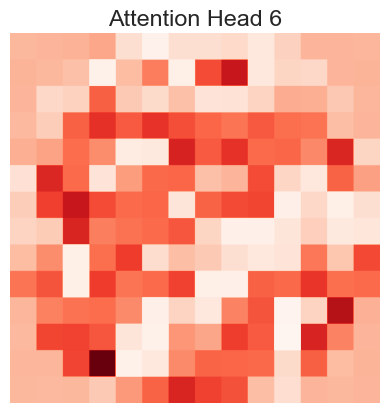

In [98]:
for idx, atn_map in enumerate(attentions):
    # Make the sequential color palette more extreme to highlight the attention
    plt.imshow(atn_map, cmap="Reds", norm=colors.PowerNorm(gamma=2))
    plt.title(f"Attention Head {idx+1}")
    plt.axis("off")
    plt.savefig(f"{save_path}/attention_head_{idx+1}.png", bbox_inches="tight")
    plt.show()